In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from discopy.grammar import Word
from discopy.rigid import Cup, Id, Ty
import torch
import random
from sentence_transformers import SentenceTransformer
from lambeq import LossFunction, PennyLaneModel, PytorchTrainer, QuantumTrainer, SPSAOptimizer, NumpyModel, MSELoss, Dataset, AtomicType, IQPAnsatz, Sim14Ansatz, Sim15Ansatz, StronglyEntanglingAnsatz, BobcatParser
from lambeq.pregroups import remove_cups
import jax as jnp
from jax import numpy as jnp

import os
import pickle
EPOCHS = 2
SEED = 42
BATCH_SIZE = 2
NOUN_QUBIT_COUNT = 1
SENTENCE_QUBIT_COUNT = 1
OPTIMIZER_PARAM = {'a': 0.75, 'c': 0.1, 'A':0.01*EPOCHS}

c:\Users\henry\Desktop\MastersProject\quantum_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def read_and_preprocess_data():
    df = pd.read_csv('Data/LargerSadrKartTransative.txt', sep=' ')
    # assign column names to the dataframe
    df.columns = ['annotator', 'subject1', 'verb1', 'object1', 'subject2', 'verb2', 'object2', 'score']
    # group the data by the three sentence columns and calculate the mean and standard deviation of the score column
    grouped_data = df.groupby(['subject1', 'verb1', 'object1', 'subject2', 'verb2', 'object2']).agg({'score': [np.mean, np.std]}).reset_index()
    # flatten the multi-level column names of the grouped data
    grouped_data.columns = [' '.join(col).strip() for col in grouped_data.columns.values]
    # rename the mean and std columns to 'score' and 'range' respectively
    grouped_data.rename(columns={'score mean': 'score', 'score std': 'range'}, inplace=True)
    grouped_data['score'] = grouped_data['score']/grouped_data['score'].max()
    unique_word_list = []
    for ind, row in grouped_data.iterrows():
        for i in [row['subject1'],row['verb1'],row['object1'], row['subject2'],row['verb2'],row['object2']]:
            unique_word_list.append(i)
    unique_word_list = list(set(unique_word_list)) #Makes word_list from word_list's unique elements
    grouped_data.to_csv("Data/AveragedLargerSadrKartTransative.txt")
    # Create an instance of MinMaxScaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    # Rescale the 'score' column
    grouped_data['score'] = scaler.fit_transform(grouped_data[['score']])
    return grouped_data, unique_word_list
dataset, unique_word_list = read_and_preprocess_data()

In [4]:
def DimReduceByPCA(input_array, new_dims):
	pca = PCA(n_components = new_dims)
	pca.fit(input_array)
	data_pca = pca.transform(input_array)
	return data_pca

def dimensionality_reduction(embedder, unique_word_list):
    #Making a dict of words as keys do our dimensionality vectors: {word: {dim_method : vector}}
    corpus_array = np.zeros(shape=(len(unique_word_list), 384))
    word_vector_dict = {}
    for i, word in enumerate(unique_word_list):
            vector = embedder.encode(word)
            word_vector_dict.update({word: {len(vector):vector}})
            corpus_array[i] = vector
            
    for j in range(12):
        pca_dim = j
        pca = DimReduceByPCA(corpus_array, pca_dim)
        for i, word in enumerate(unique_word_list):
                word_vector_dict[word].update({"pca_"+str(pca_dim):pca[i]})
    return word_vector_dict

embedder = SentenceTransformer('paraphrase-MiniLM-L6-v2')
word_vector_dict = dimensionality_reduction(embedder, unique_word_list)

In [10]:
def retrive_nth_rows_sentences(data, row1, row2=None):
    if not row2:
        row2=row1
    sentence1 = data['subject'+str(1)][row1] + " " + data['verb'+str(1)][row1]  + " " + data['object'+str(1)][row1] 
    sentence2 = data['subject'+str(2)][row2] + " " + data['verb'+str(2)][row2]  + " " + data['object'+str(2)][row2] 
    return sentence1, sentence2

def make_sentence_a_state(sentence):
    diagram = diagram_to_sentence(sentence.split(" "))
    diagram = remove_cups(diagram)
    return diagram

def make_diagram_a_circuit(diagram, ansatz, dagger=False):
    discopy_circuit = ansatz(diagram)
    if dagger:
        discopy_circuit = discopy_circuit.dagger()
    return discopy_circuit

def concat_circuits_into_inner_product(circuit1, circuit2):
    concat_circuit = circuit1 >> circuit2
    return concat_circuit

def make_diagrams(data, sentence1, sentence2=None):
    if type(sentence1) == int:
        sentence1, sentence2 = retrive_nth_rows_sentences(data, sentence1, sentence2)
    diagram1 = make_sentence_a_state(sentence1)
    diagram2 = make_sentence_a_state(sentence2)
    return diagram1, diagram2

def diagram_to_sentence(word_list):
    n, s = Ty('n'), Ty('s')
    words = [
        Word(word_list[0], n),
        Word(word_list[1], n.r @ s @ n.l),
        Word(word_list[2], n)
    ]
    cups = Cup(n, n.r) @ Id(s) @ Cup(n.l, n)
    assert Id().tensor(*words) == words[0] @ words[1] @ words[2]
    assert Ty().tensor(*[n.r, s, n.l]) == n.r @ s @ n.l
    diagram = Id().tensor(*words) >> cups
    return diagram

def plot_model_over_training(trainer):
    """
    Plots the training of a model in two graphs:
        - Traing Loss vs validation Loss, colour is epoch
        - Two Losses against epochs. 
    """
    epoch_count = range(trainer.epochs)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    fig.figsize=(20,10)

    ax1.scatter(trainer.val_costs,trainer.train_epoch_costs,c=epoch_count, cmap='gray')
    ax1.set_xlabel("Validation Loss")
    ax1.set_ylabel("Training Loss")
    ax1.set_title("Loss of Validation and Training, should be a nice curve")

    ax2.set_title("Train & Val Losses")
    ax2.plot(epoch_count, trainer.val_costs, label = 'Validate')
    ax2.plot(epoch_count, trainer.train_epoch_costs, label = 'Train')
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Loss")
    ax2.legend()
    fig.show()

def retrive_word_param_from_symbols(word_symbol, noun_parameters, subject_parameters):
    word = word_symbol.name.split("_")
    word_string = word[0]
    word_type = word[-2]
    if word_type == "n":
        word_dims = get_word_dims_from_ansatz(ANSATZ)[0]
    elif "@" in word_type:
        word_dims = get_word_dims_from_ansatz(ANSATZ)[1] 
    word_index = int(word[-1])
    return word_string, word_dims, word_index

def get_word_dims_from_ansatz(ANSATZ):
    noun = ANSATZ.ob_map[Ty('n')]
    sent = ANSATZ.ob_map[Ty('s')]
    if isinstance(ANSATZ, IQPAnsatz):
        noun_parameters = 3 if noun == 1 else (noun-1)
        subject_parameters = noun + noun + sent - 1
        return noun_parameters, subject_parameters
    if isinstance(ANSATZ, Sim14Ansatz):
        noun_parameters = 3 if noun == 1 else noun*4
        subject_parameters = 4*(noun + noun + sent)
        return noun_parameters, subject_parameters
    if isinstance(ANSATZ, Sim15Ansatz):
        noun_parameters = 3 if noun == 1 else noun*2
        subject_parameters = 2*(noun + noun + sent)
        return noun_parameters, subject_parameters
    if isinstance(ANSATZ, StronglyEntanglingAnsatz):
        print("ERROR NOT IMPLEMENTED YET")
        pass

def pca_to_rotations(symbols):
    noun_parameters, subject_parameters = get_word_dims_from_ansatz(ANSATZ)

    weights = np.zeros(shape=(len(symbols)))
    for i, word_symbol in enumerate(symbols):
        word_string, word_dims, word_index = retrive_word_param_from_symbols(word_symbol, noun_parameters, subject_parameters)
        weights[i] = word_vector_dict[word_string]['pca_'+str(word_dims)][word_index]/(2*np.pi)
    return weights

def normal_distribution_to_rotations(symbols):
    noun_parameters, subject_parameters = get_word_dims_from_ansatz(ANSATZ)

    weights = np.zeros(shape=(len(symbols)))
    for i, word_symbol in enumerate(symbols):
        word_string, word_dims, word_index = retrive_word_param_from_symbols(word_symbol, noun_parameters, subject_parameters)
        
        mean_of_word = word_vector_dict[word_string][384].mean()
        std_of_word = word_vector_dict[word_string][384].std()
        s = np.random.normal(mean_of_word, std_of_word, 1)

        weights[i] = s
    return weights

def make_circuit_from_diagrams(diagram1, diagram2, ansatz, drawing=False):
    discopy_circuit1 = make_diagram_a_circuit(diagram1, ansatz)
    discopy_circuit2 = make_diagram_a_circuit(diagram2, ansatz, dagger=True)
    discopy_circuit = concat_circuits_into_inner_product(discopy_circuit1, discopy_circuit2)

    if drawing:
        discopy_circuit1.draw(figsize=(5, 5))
        discopy_circuit2.draw(figsize=(5, 5))
        discopy_circuit.draw(figsize=(5, 10))   

    pennylane_circuit = discopy_circuit.to_pennylane()
    return pennylane_circuit, discopy_circuit

def make_circuit_from_df_row(data, row_number, ansatz):
    diagram1, diagram2 = make_diagrams(data, row_number)
    qml_circuit, discopy_circuit = make_circuit_from_diagrams(diagram1, diagram2, ansatz, False)
    return qml_circuit, discopy_circuit

In [13]:
def get_datasets(ansatz):
    labels = dataset['score']

    training = pd.read_csv("Data/TrainingData.txt")
    test = pd.read_csv("Data/TestData.txt")

    train_data =  [make_circuit_from_df_row(training, i, ansatz)[1] for i in range(len(training))]
    train_labels = labels[training['Unnamed: 0'].values]
    val_data = [make_circuit_from_df_row(test, i, ansatz)[1] for i in range(len(test))] 
    val_labels = labels[test['Unnamed: 0'].values]

    diagrams = train_data + val_data

    train_dataset = Dataset(train_data,train_labels,batch_size=BATCH_SIZE)
    val_dataset = Dataset(val_data, val_labels, batch_size=BATCH_SIZE)
    return diagrams, train_dataset, val_dataset

In [14]:
class EncodedNumpyModel(NumpyModel):
     def initialise_weights(self) -> None:
        if not self.symbols:
            raise ValueError('Symbols not initialised. Instantiate through '
                            '`from_diagrams()`.')
        self.weights = self.param_initialise_method(self.symbols)

In [19]:
def run_quantum_trainer(data, model_type, ansatz, loss_function, optimizer, num_epochs, batch_size, seed):
    diagrams, train_dataset, val_dataset = get_datasets(ansatz)
    ansatz_name = ansatz.__class__.__name__.lower()
    loss_name = loss_function.__class__.__name__.lower()
    optimizer_name = optimizer.__name__.lower()

    # Initialize the model and trainer based on the provided ansatz
    if model_type == 'random':
        model = NumpyModel.from_diagrams(diagrams, use_jit=True)
    elif model_type == 'pca':
        model = EncodedNumpyModel.from_diagrams(diagrams, use_jit=True)
        model.type_of_encoding = 'pca'
        model.param_initialise_method = pca_to_rotations
        model.initialise_weights()
    elif model_type == 'normal':
        model = EncodedNumpyModel.from_diagrams(diagrams, use_jit=True)
        model.param_initialise_method = normal_distribution_to_rotations
        model.initialise_weights()
    else:
        raise ValueError(f"Invalid ansatz: {ansatz_name}")

    trainer = QuantumTrainer(
        model,
        loss_function=loss_function,
        epochs=num_epochs,
        optimizer=optimizer,
        optim_hyperparams=OPTIMIZER_PARAM,
        evaluate_on_train=True,
        verbose='text',
        seed=seed
    )
    trainer.fit(train_dataset, val_dataset, logging_step=1)
    
    model_params = model.weights

    model_data = {
        'ansatz_name': ansatz_name,
        'loss_name': loss_name,
        'optimizer_name': optimizer_name,
        'num_epochs': num_epochs,
        'batch_size': batch_size,
        'seed': seed,
        'model_params': model_params,
        'training_losses': trainer.train_epoch_costs,
        'epochs': EPOCHS
    }

    model_filename = f"{model_type}_{ansatz_name}_{loss_name}_{optimizer_name}_epochs{num_epochs}_batch{batch_size}_seed{seed}.pkl"
    model_filepath = os.path.join("models", model_filename)

    os.makedirs("models", exist_ok=True)

    with open(model_filepath, 'wb') as model_file:
        pickle.dump(model_data, model_file)

    return model, trainer.train_epoch_costs, EPOCHS

In [20]:
ANSATZ_PARAM = {AtomicType.NOUN: NOUN_QUBIT_COUNT, AtomicType.SENTENCE: SENTENCE_QUBIT_COUNT}

ansatz_config = {
        'IQP': IQPAnsatz(ANSATZ_PARAM, n_layers=1),
        'Sim14': Sim14Ansatz(ANSATZ_PARAM, n_layers=1),
        'Sim15': Sim15Ansatz(ANSATZ_PARAM, n_layers=1),
    }

loss_function_config = {
        'mse': MSELoss(),
    }

optimizer_config = {
        'spsa': SPSAOptimizer,
    }

for ansatz_name, ansatz in ansatz_config.items():
    for loss_name, loss_function in loss_function_config.items():
        for optimizer_name, optimizer in optimizer_config.items():
            model_config = 'random'
            run_quantum_trainer(dataset, model_config, ansatz, loss_function, optimizer, EPOCHS, BATCH_SIZE, SEED)

Epoch 1:  train/loss: 0.5590   valid/loss: 0.6138
Epoch 2:  train/loss: 0.5525   valid/loss: 0.6173

Training completed!
c:\Users\henry\Desktop\MastersProject\quantum_env\lib\site-packages\discopy\messages.py:95: UserWarning: Since discopy v0.4.3 the behaviour of permutation has changed. Pass inverse=False to get the default behaviour.
  warnings.warn(message)
Epoch 1:  train/loss: 0.5719   valid/loss: 0.6058
Epoch 2:  train/loss: 0.5571   valid/loss: 0.6122

Training completed!
Epoch 1:  train/loss: 0.5572   valid/loss: 0.6162
Epoch 2:  train/loss: 0.5582   valid/loss: 0.6140

Training completed!


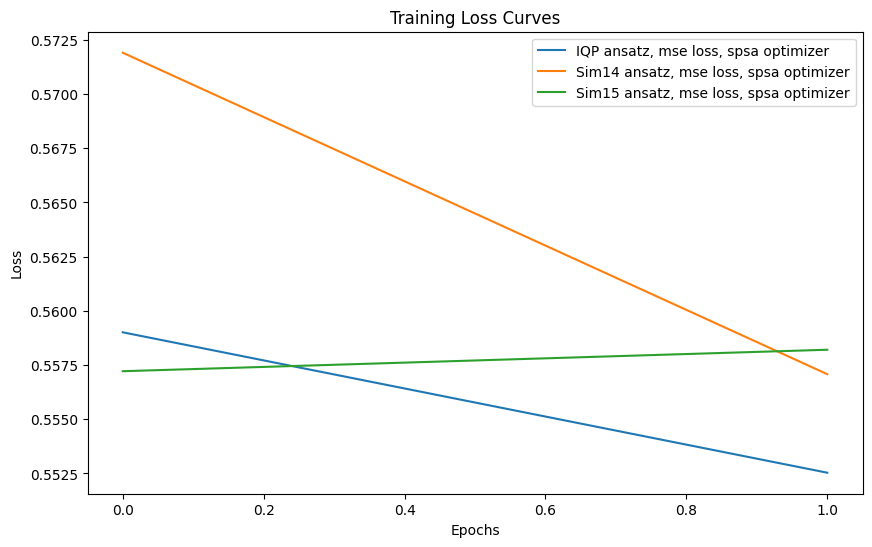

In [33]:
import os
import pickle
import matplotlib.pyplot as plt

def load_model_data(file_path):
    with open(file_path, 'rb') as model_file:
        model_data = pickle.load(model_file)
    return model_data

def plot_training_loss_curve(model_data):
    training_losses = model_data['training_losses']
    epochs = model_data['epochs']
    epoch_count = range(epochs)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(epoch_count, training_losses, label='Training Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss Curve')
    ax.legend()
    plt.show()

def plot_all_training_loss_curves(ansatz_config, loss_function_config, optimizer_config):
    fig, ax = plt.subplots(figsize=(10, 6))

    for ansatz_name, ansatz in ansatz_config.items():
        for loss_name, loss_function in loss_function_config.items():
            for optimizer_name, optimizer in optimizer_config.items():
                model_type = 'random'  # Change this based on the model type you want to use

                # Load the saved model data
                model_filename = f"{model_type}_{ansatz_name}ansatz_{loss_name}loss_{optimizer_name}optimizer_epochs{EPOCHS}_batch{BATCH_SIZE}_seed{SEED}.pkl"
                model_filepath = os.path.join("models/", model_filename)
                with open(model_filepath, 'rb') as model_file:
                    model_data = pickle.load(model_file)

                # Extract training losses and epochs
                training_losses = model_data['training_losses']
                epochs = model_data['epochs']
                epoch_count = range(epochs)

                # Plot the training loss curve for the current model
                label = f"{ansatz_name} ansatz, {loss_name} loss, {optimizer_name} optimizer"
                ax.plot(epoch_count, training_losses, label=label)

    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss Curves')
    ax.legend()
    plt.show()

# Call the function to plot all training loss curves
plot_all_training_loss_curves(ansatz_config, loss_function_config, optimizer_config)